In [82]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-fantom-test"
GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/id/QmU3jQEGpsQTMBV6JuEja3BdqPqdmAP5AuxTcCgoWwnuWa"

def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()['data']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [83]:
fee_query = """
{ pools(first: 1000) {
  isV2
  id
  name
  dailyPoolSnapshots(first: 1000 orderBy: timestamp orderDirection: desc) {
    timestamp
    adminFeesUSD
    lpFeesUSD
    totalDailyFeesUSD
    eventFeesUSD
    baseApr
    virtualPrice
    tvl
  }
}
}
"""

In [84]:
data = grt_query(fee_query)['pools']
df = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df['totalDailyFeesUSD'] = df['totalDailyFeesUSD'].astype(float)
df['eventFeesUSD'] = df['eventFeesUSD'].astype(float) * 2
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values('timestamp', ascending=True)
df

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,virtualPrice,tvl
7603,False,0x92d5ebf3593a92888c25c0abef126583d4b5312e,Curve.fi fUSDT/DAI/USDC,2021-09-15,0,0,0.00,0.00,0,1013418284088711008,112296796.991341
4347,False,0x3ef6a01a0f81d6046290f3e2a8c5b843e738e604,Curve.fi WBTC/renBTC,2021-09-15,0,0,0.00,0.00,0,1001289788650392083,746061999.3737567051744536333606454
2900,False,0x27e611fd27b276acbd5ffd632e5eaebec9761e40,Curve.fi DAI/USDC,2021-09-15,0,0,0.00,0.00,0,1008428923639104648,157079756.479740671524196489
7602,False,0x92d5ebf3593a92888c25c0abef126583d4b5312e,Curve.fi fUSDT/DAI/USDC,2021-09-16,1059.468853794674538129455792106669,1059.468853794674538129455792106669,2118.94,0.00,0.000009434542054448518578663695229698477,1013427845226130990,231815757.7337625208453999245481821
4346,False,0x3ef6a01a0f81d6046290f3e2a8c5b843e738e604,Curve.fi WBTC/renBTC,2021-09-16,1739.366897072648345829490216538275,1739.366897072648345829490216538275,3478.73,0.00,0.000002331397254561511300767662891080719,1001292123054656363,754947218.9127074613301669761197279
...,...,...,...,...,...,...,...,...,...,...,...
10188,False,0xb3045222d3f3725c4beb1047f6c54514b3333ed7,Curve.fi Factory Plain Pool: YFI/wFTM,2022-05-11,0,0,0.00,0.00,0,0,0
4456,False,0x43ec4106b3a09b17f8669e268f36cc5cdd5f356f,Curve.fi Factory Plain Pool: renBUSD,2022-05-11,0,0,0.00,0.00,0,1000003591731273744,21.159924000000000001
4618,False,0x46f5ea3b7867b451eb1568fa820a6e89c5492795,Curve.fi Factory Plain Pool: linSPIRIT/SPIRIT,2022-05-11,0,0,0.00,0.00,0,0,0
1114,False,0x138ccfe5d99c139b9c4918ace02a082ca67693bb,Curve.fi Factory USD Metapool: Creditum,2022-05-11,0,0,0.00,0.00,0,0,99.88183020422200920055656299353973


<AxesSubplot:xlabel='timestamp'>

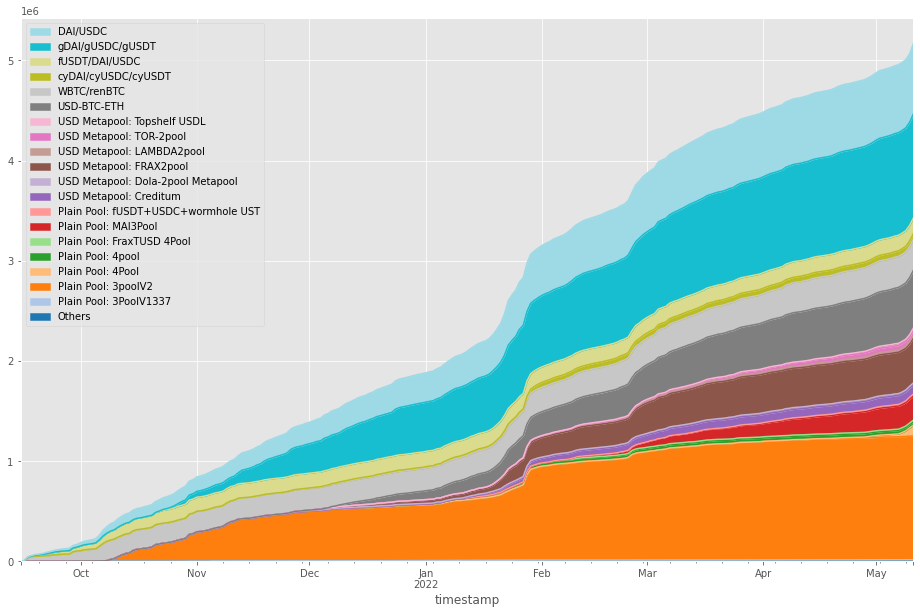

In [85]:
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data = df[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name', aggfunc='sum')
top_performers = chart_data.mean().sort_values(ascending=False)[:19].index.tolist()
df_others = df.copy()
df_others['name'] = df_others['name'].apply(lambda x: x if x in top_performers else 'Others')
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data_others = df_others[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name', aggfunc='sum')
chart_data_others['Others'] = df_others[df_others['name'] == 'Others'][['timestamp', 'cumulativeDailyFeesUSD']].groupby('timestamp').sum()['cumulativeDailyFeesUSD']
chart_data_others.columns = [s.replace('Curve.fi Factory ', '').replace('Curve.fi ', '').replace('Curve ', '') for s in chart_data_others.columns]
cols = chart_data_others.columns.tolist()
chart_data_others[([cols[-1], *cols[1:-1], cols[0]])].plot.area(figsize=(16, 10), legend='reverse', colormap="tab20")

In [86]:
WEEK = 3600 * 24 * 7
df_week = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df_week['totalDailyFeesUSD'] = df_week['totalDailyFeesUSD'].astype(float)
df_week['timestamp'] = df_week['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_week['timestamp'] = pd.to_datetime(df_week['timestamp'],unit='s')
df_week = df_week.sort_values('timestamp', ascending=True)
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum()

,totalDailyFeesUSD
timestamp,
2021-09-09,0.00
2021-09-16,88905.42
2021-09-23,68236.73
2021-09-30,102154.57
2021-10-07,210637.61
2021-10-14,94949.14
2021-10-21,139773.88
2021-10-28,158234.36
2021-11-04,138467.41


In [87]:
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum().sum() / 2

totalDailyFeesUSD   2584491.06
dtype: float64

In [88]:
pd.set_option('display.max_rows', 500)
#df['tvl'] = df['tvl'].astype(float)
df['cumulativeDailyFeesUSD'] = df['cumulativeDailyFeesUSD'].astype(float)
df['baseApr'] = df['baseApr'].astype(float)
df[df['name'] == 'Curve.fi Factory Plain Pool: 4pool'].head(500)

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,virtualPrice,tvl,cumulativeDailyFeesUSD
9739,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-01,0,0,0.00,0.00,0.00,0,0,0.00
9738,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-02,0,0,0.00,0.00,0.00,1000283012758758445,593.7177258452965063997474525455181,0.00
9737,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-03,0.07302976104911878951051348666789532,0.07302976104911878951051348666789528,0.15,0.00,0.00,1000406051748876620,594.3407230615084509632656152424897,0.15
9736,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-04,0.1688773717226026149862830655820575,0.1688773717226026149862830655820575,0.34,0.00,0.00,1000690309478692741,1557.92803811814847178507713109826,0.48
9735,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-05,1.533135854469677058692021218057817,1.533135854469677058692021218057817,3.07,0.00,0.00,1001675075241388253,2786.920291815537034808461007896225,3.55
9734,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-06,4.543832910991231256321899810079667,4.543832910991231256321899810079667,9.09,0.00,0.00,1003308219966182805,14232.43441766910824094041819353228,12.64
9733,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-07,0,0,0.00,0.00,127.90,129330821243006875837,24188.80240368496760660319200937879,12.64
9732,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-08,43.69784855970600428306421469772057,43.69784855970600428306421469772057,87.40,0.00,0.00,129564461526079276554,5030.445479510815546210964381324983,100.03
9731,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-09,0.7829020854508083360683273034758834,0.7829020854508083360683273034758836,1.57,0.00,0.00,129584626000089030186,893.3465729643554175812805920779353,101.60
9730,False,0xad71fc10fca8ce6a98843a64b95e0c63516ca7f3,Curve.fi Factory Plain Pool: 4pool,2021-10-10,0.03367739144097407808136880747612525,0.03367739144097407808136880747612525,0.07,0.00,0.00,129589511083109000927,792.1417044125312729583841491927779,101.67


In [89]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df[df['name'] == 'Curve.fi Factory Plain Pool: 4pool'].head(500)[['timestamp', 'name', 'baseApr', 'virtualPrice', 'tvl', 'cumulativeDailyFeesUSD']].iloc[[5,6]]

,timestamp,name,baseApr,virtualPrice,tvl,cumulativeDailyFeesUSD
9734,2021-10-06,Curve.fi Factory Plain Pool: 4pool,0.00,1003308219966182805,14232.43441766910824094041819353228,12.64
9733,2021-10-07,Curve.fi Factory Plain Pool: 4pool,127.90,129330821243006875837,24188.80240368496760660319200937879,12.64
